# Keras Tutorial

Using Keras on MNIST.

Sources: 
- https://elitedatascience.com/keras-tutorial-deep-learning-in-python
- https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb
- https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
- https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb

In [1]:
import keras
import theano
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
%matplotlib inline

/Users/hannes/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot

from keras import backend as K

In [3]:
from keras.datasets import mnist

In [4]:
from IPython.display import SVG

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

----

(60000, 28, 28)

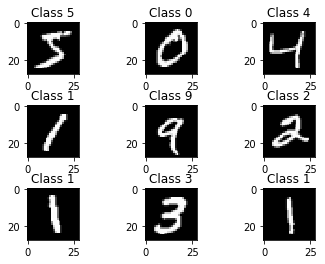

In [5]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# We have 60,000 training examples. Each is of shape 28x28.
X_train.shape
_, num_rows, num_cols = X_train.shape

for i in range(9):
    _ = plt.subplot(3, 3, i+1)
    _ = plt.imshow(X_train[i], cmap='gray', interpolation='none')
    _ = plt.title("Class {}".format(y_train[i]))
    plt.subplots_adjust(hspace=0.6)

In [6]:
# We have 60,000 lables for training, but labels are not in one-hot encoding yet.
y_train.shape
y_train[:5]

(60000,)

array([5, 0, 4, 1, 9], dtype=uint8)

----
### Preprocessing data
From https://elitedatascience.com/keras-tutorial-deep-learning-in-python:

_"When using the Theano backend, you must explicitly declare a dimension for the depth of the input image. For example, a full-color image with all 3 RGB channels will have a depth of 3._

_Our MNIST images only have a depth of 1, but we must explicitly declare that._

_In other words, we want to transform our dataset from having shape (n, width, height) to (n, depth, width, height)."_

In [7]:
# Reshaping input data
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, num_rows, num_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, num_rows, num_cols)
    input_shape = (1, num_rows, num_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], num_rows, num_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], num_rows, num_cols, 1)
    input_shape = (num_rows, num_cols, 1)

In [8]:
# Converting data types and normalizing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

#### We need to one-hot encode the labels.

In [9]:
num_classes = max(y_train)+1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

----
### Let's start the modeling

Our goal is to maximize accuracy, so we are going accuracy as the metric.

We are building a sequential model that has... 
- two convolutional layers
- followed by maxpooling
- followed by a dropout 'layer'
- flattening of the input
- a fully-connected layer
- a dropout layer
- a fully-connected layer with 10 output units (one for each class) using softmax activation to give us the probability of an image belonging to class c

In [10]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
# We are using Adadelta as the optimizer. It dynamically adapts the learning rate.

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [12]:
model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 217s 4ms/step - loss: 0.2745 - acc: 0.9169 - val_loss: 0.0706 - val_acc: 0.9788
Epoch 2/10
60000/60000 [==============================] - 215s 4ms/step - loss: 0.0793 - acc: 0.9765 - val_loss: 0.0483 - val_acc: 0.9845
Epoch 3/10
60000/60000 [==============================] - 211s 4ms/step - loss: 0.0576 - acc: 0.9830 - val_loss: 0.0399 - val_acc: 0.9866
Epoch 4/10
60000/60000 [==============================] - 213s 4ms/step - loss: 0.0461 - acc: 0.9861 - val_loss: 0.0370 - val_acc: 0.9882
Epoch 5/10
60000/60000 [==============================] - 204s 3ms/step - loss: 0.0385 - acc: 0.9881 - val_loss: 0.0308 - val_acc: 0.9890
Epoch 6/10
60000/60000 [==============================] - 206s 3ms/step - loss: 0.0343 - acc: 0.9892 - val_loss: 0.0339 - val_acc: 0.9887
Epoch 7/10
60000/60000 [==============================] - 208s 3ms/step - loss: 0.0304 - acc: 0.9905 - val_loss: 0.0311 - 

Test loss: 0.027653929015428003
Test accuracy: 0.9908


----
### Let's try to understand how well the model is doing, where it is having problems, and what it learned

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

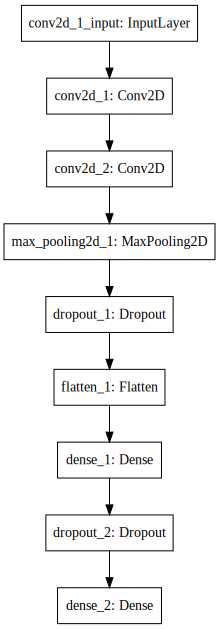

In [13]:
# First, a summary of the model
model.summary()

print("\n\n\n--------\nAs a reminder - this is the model:")
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### What did the model get wrong - what did it get right?

In [14]:
#Predict_classes returns the most likely class
predictions = model.predict_classes(X_test)

correct_class = np.argmax(y_test, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predictions == correct_class)[0]
incorrect_indices = np.nonzero(predictions != correct_class)[0]

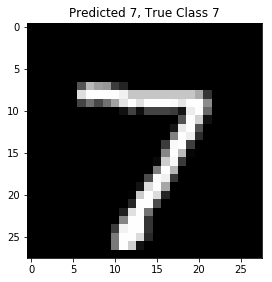

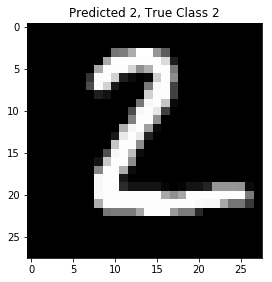

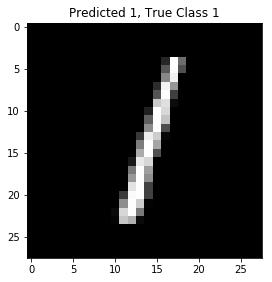

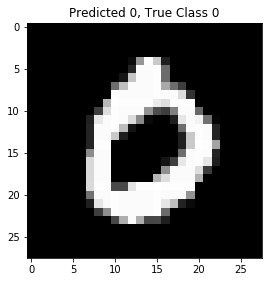

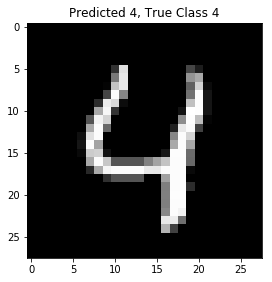

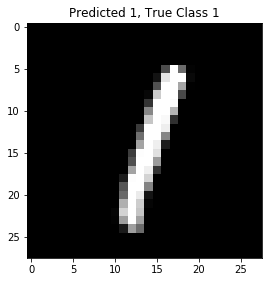

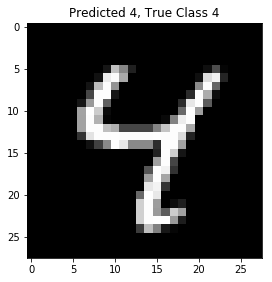

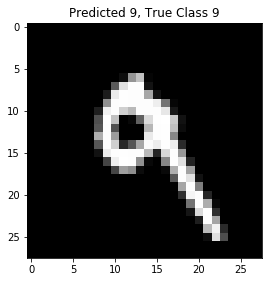

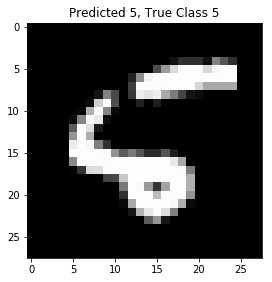

In [15]:
#Correct classifications
for i in range(9):
    _ = plt.figure()
    _ = plt.imshow(X_test[correct_indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    _ = plt.title("Predicted {}, True Class {}".format(predictions[correct_indices[i]], 
                                                       correct_class[correct_indices[i]]))
    _ = plt.tight_layout()
    

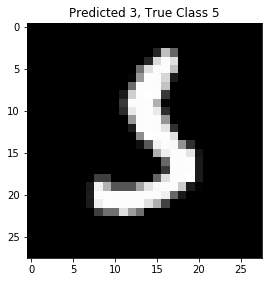

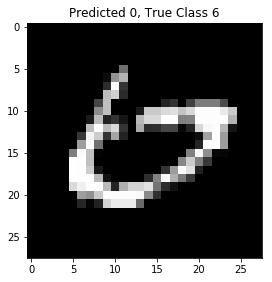

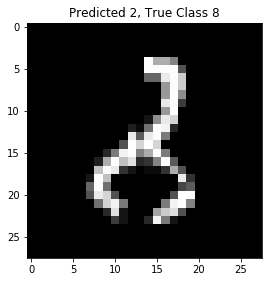

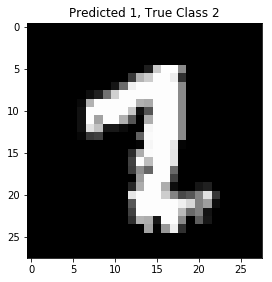

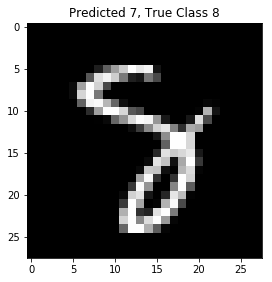

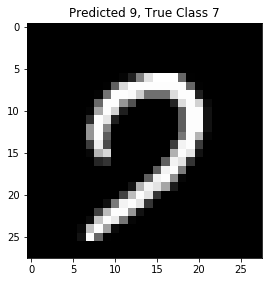

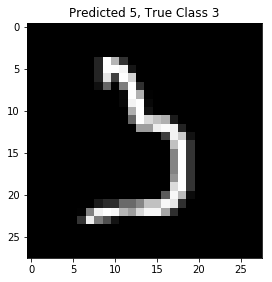

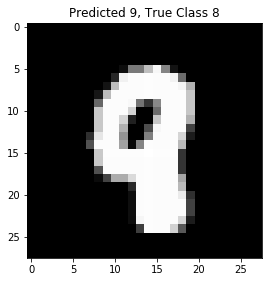

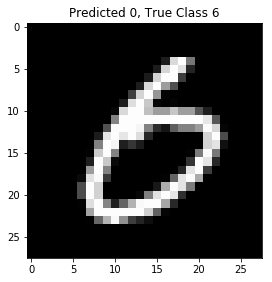

In [16]:
#Incorrect classifications
for i in range(9):
    _ = plt.figure()
    _ = plt.imshow(X_test[incorrect_indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    _ = plt.title("Predicted {}, True Class {}".format(predictions[incorrect_indices[i]], 
                                                       correct_class[incorrect_indices[i]]))
    _ = plt.tight_layout()

----
# Visualizations

We now seek to visualize the model to try to understand what it learned. I will follow https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb to do so.

In [17]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

plt.rcParams['figure.figsize'] = (18, 6)

### We had trained the model with softmax activation function in the last layer. Softmax depends on all output values; therefore, the gradient of the output node depends on all other output nodes' activations.

Activation for class: 0


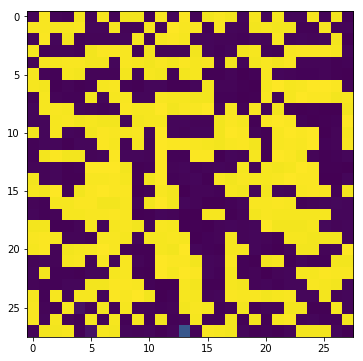

Activation for class: 1


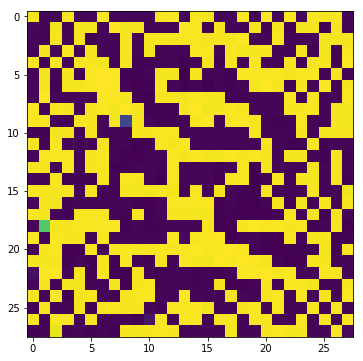

Activation for class: 2


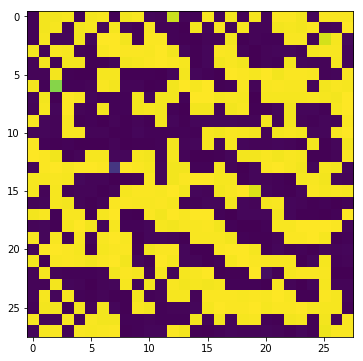

Activation for class: 3


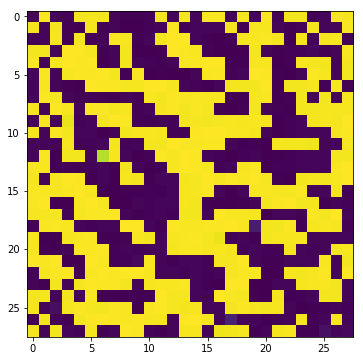

Activation for class: 4


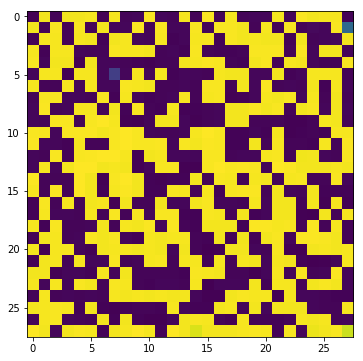

Activation for class: 5


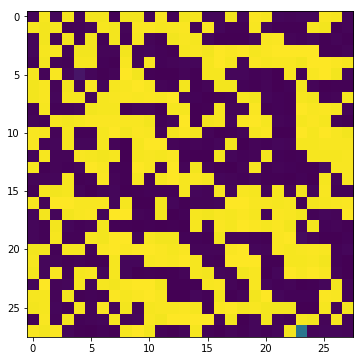

Activation for class: 6


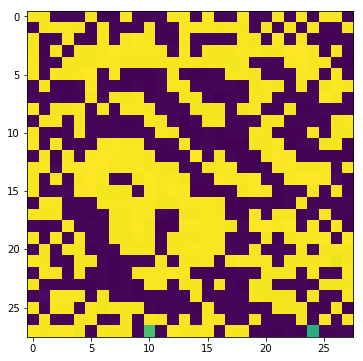

Activation for class: 7


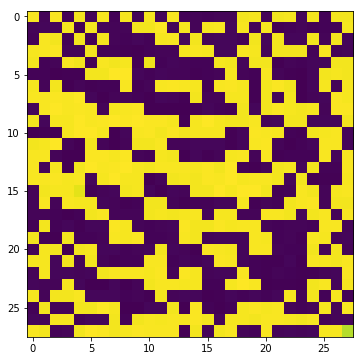

Activation for class: 8


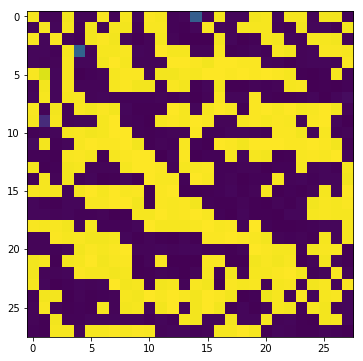

Activation for class: 9


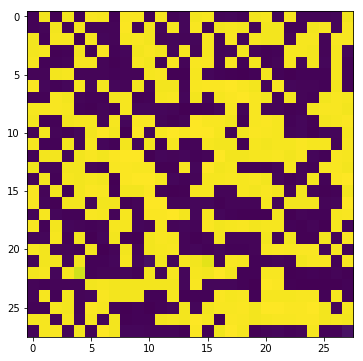

In [18]:
for i in range(10):
    print("Activation for class:", i)
    img = visualize_activation(model, layer_idx=-1, filter_indices=i, input_range=(0., 1.))
    _ = plt.imshow(img[..., 0])
    plt.show()

### To address this, we will make the prediction layer use linear activation.

Activation for class: 0


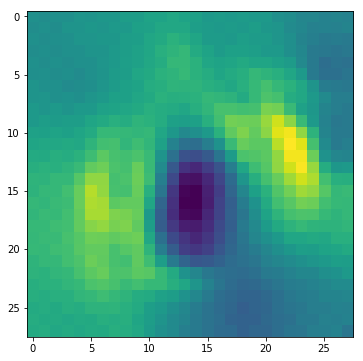

Activation for class: 1


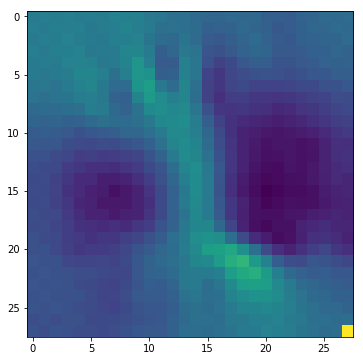

Activation for class: 2


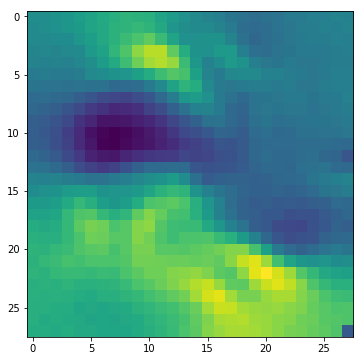

Activation for class: 3


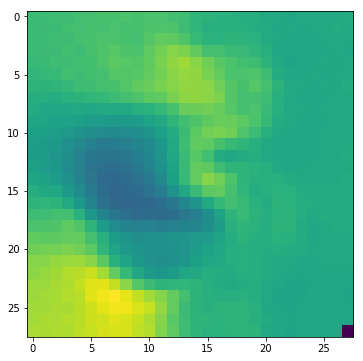

Activation for class: 4


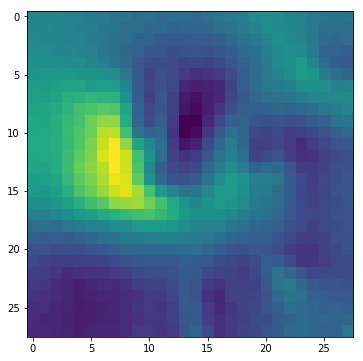

Activation for class: 5


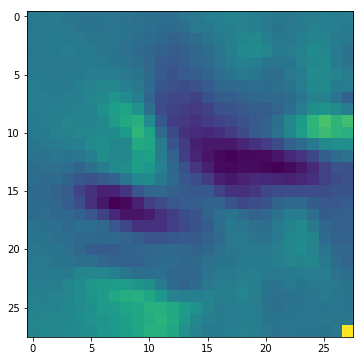

Activation for class: 6


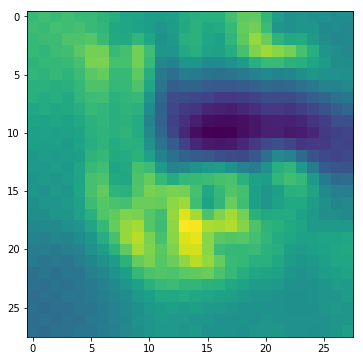

Activation for class: 7


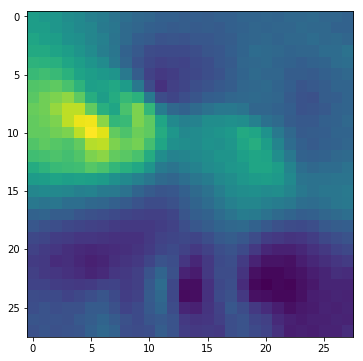

Activation for class: 8


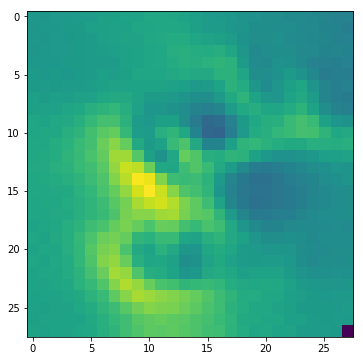

Activation for class: 9


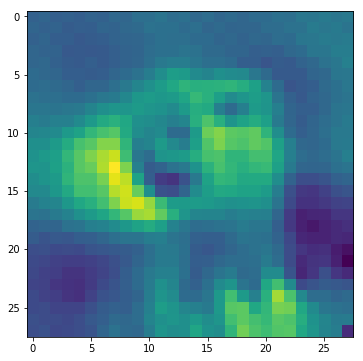

In [19]:
# Swap softmax with linear
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
for i in range(10):
    print("Activation for class:", i)
    img = visualize_activation(model, layer_idx=-1, filter_indices=i)
    _ = plt.imshow(img[..., 0])
    plt.show()

With some creativity, we can recognize the digits of the classes, but they are not very clear. According to the tutorial, this is a typical problem of activation maximization. It is supposedly a hard problem to work on because regularization parameters needs to be tuned depending on the problem. 

According to the tutorial, reasons for the current poor visualization include:

- "_The input to network is preprocessed to range (0, 1). We should specify input range = (0., 1.) to constrain the input to this range._"
- "_The regularization parameter default weights might be dominating activation maximization loss weight. One way to debug this is to use verbose=True and examine individual loss values._"

#### Lets begin with specifying the input range.

Activation for class: 0


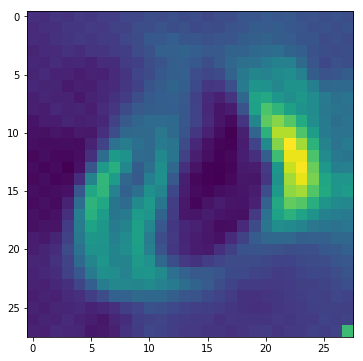

Activation for class: 1


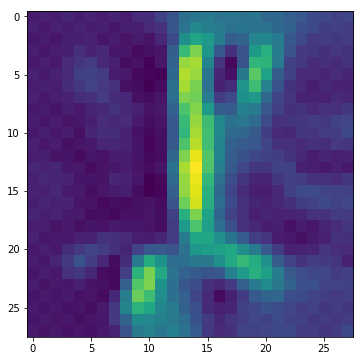

Activation for class: 2


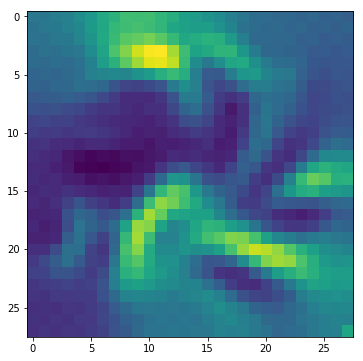

Activation for class: 3


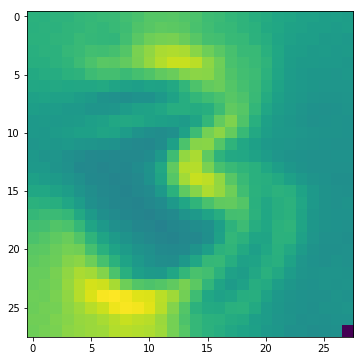

Activation for class: 4


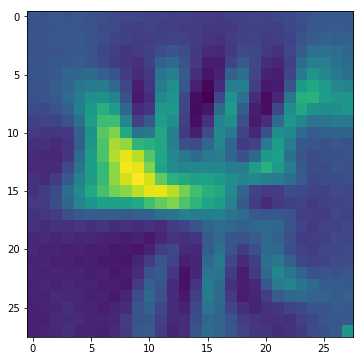

Activation for class: 5


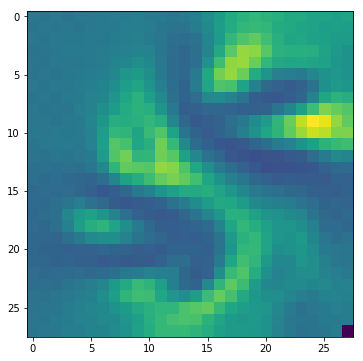

Activation for class: 6


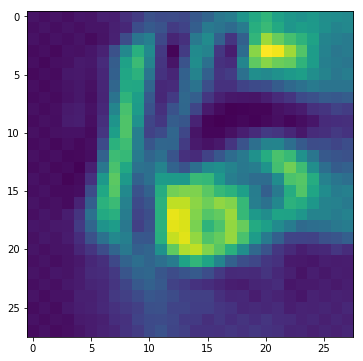

Activation for class: 7


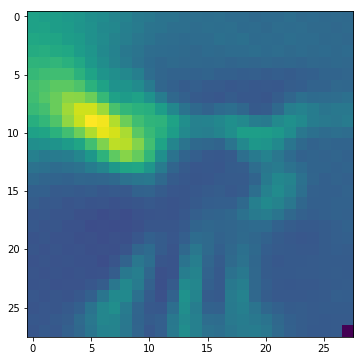

Activation for class: 8


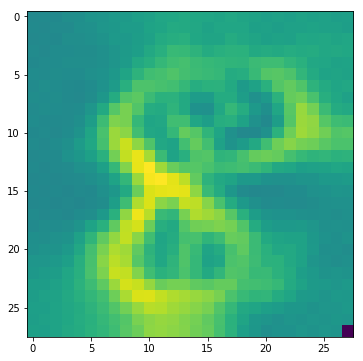

Activation for class: 9


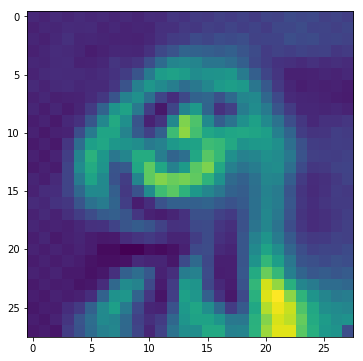

In [20]:
for i in range(10):
    print("Activation for class:", i)
    img = visualize_activation(model, layer_idx=-1, filter_indices=i, input_range=(0., 1.))
    _ = plt.imshow(img[..., 0])
    plt.show()

### That helped. Lets play with the regularization default weights.

Total variance weight is: 0.001


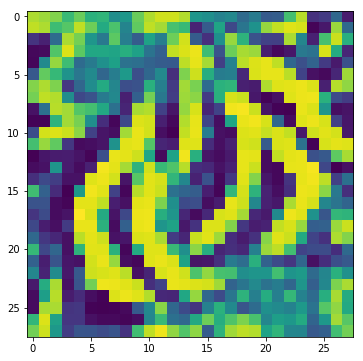

Total variance weight is: 0.01


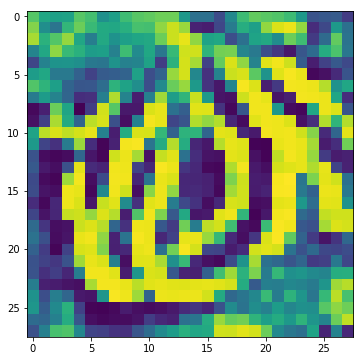

Total variance weight is: 0.1


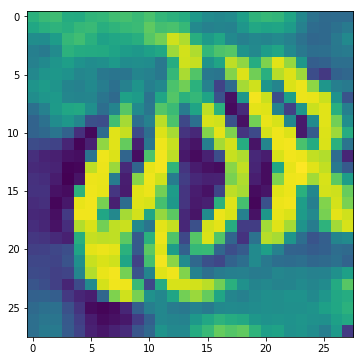

Total variance weight is: 1


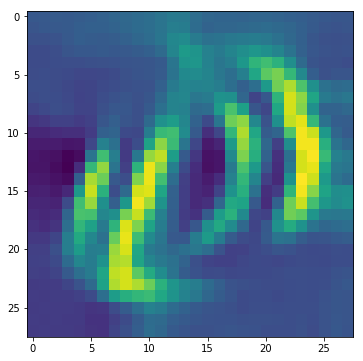

Total variance weight is: 10


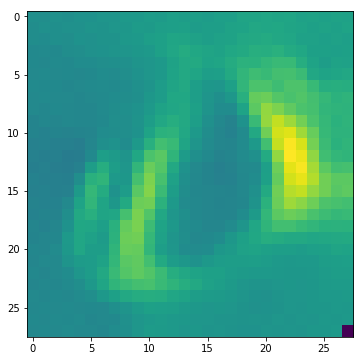

In [21]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    print("Total variance weight is:", tv_weight)
    img = visualize_activation(model, -1, filter_indices=0, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=0.)
    _ = plt.imshow(img[..., 0])
    plt.show()

lp_norm_weight is: 0.001


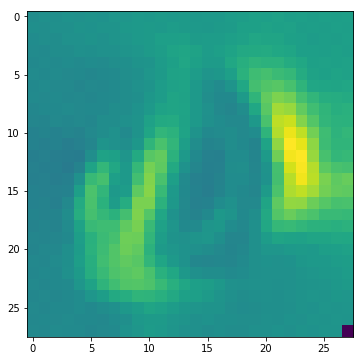

lp_norm_weight is: 0.01


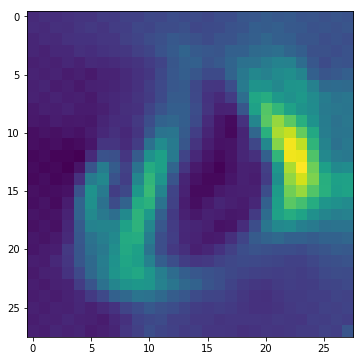

lp_norm_weight is: 0.1


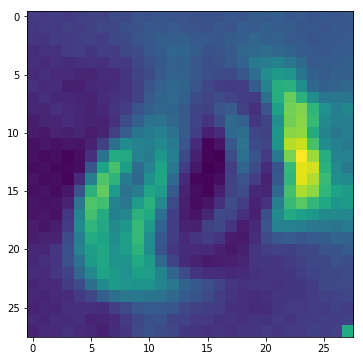

lp_norm_weight is: 1


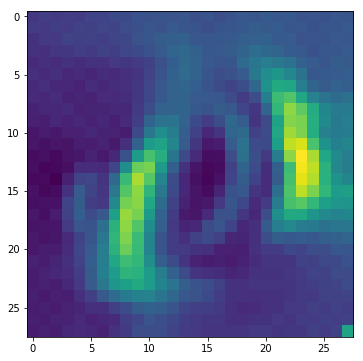

lp_norm_weight is: 10


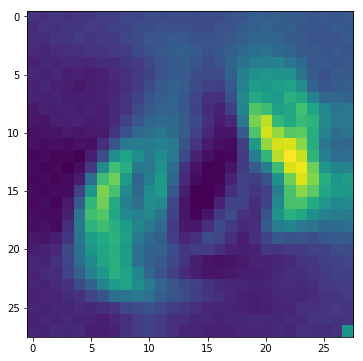

In [22]:
for lp_norm_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    print("lp_norm_weight is:", lp_norm_weight)
    img = visualize_activation(model, -1, filter_indices=0, input_range=(0., 1.), 
                               tv_weight=10, lp_norm_weight=lp_norm_weight)
    _ = plt.imshow(img[..., 0])
    plt.show()

### lp_norm_weight = 10 and tv_weight = 10 gave the best results.

# Lets print the images again with these params.

Activation for class: 0


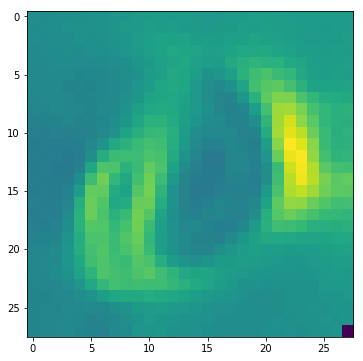

Activation for class: 1


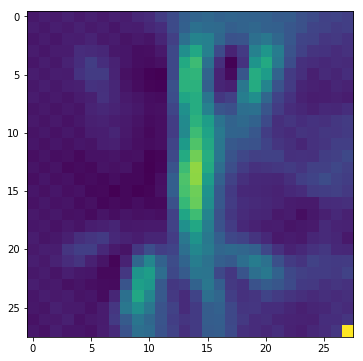

Activation for class: 2


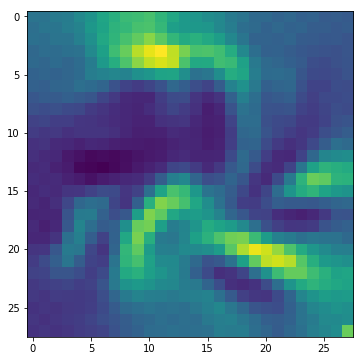

Activation for class: 3


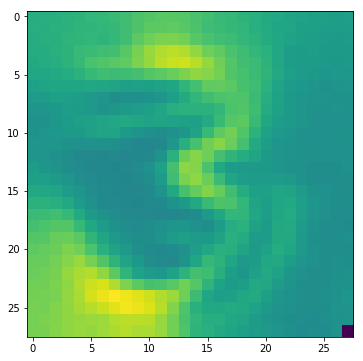

Activation for class: 4


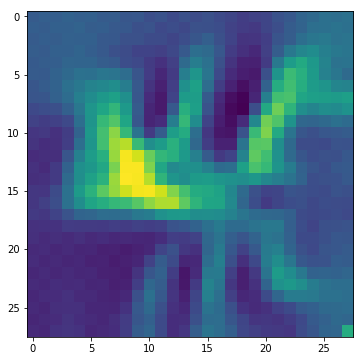

Activation for class: 5


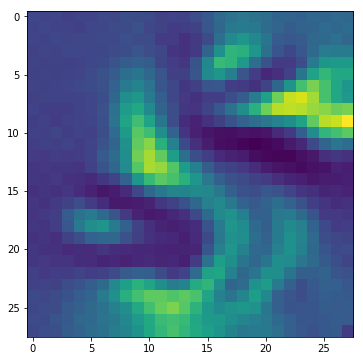

Activation for class: 6


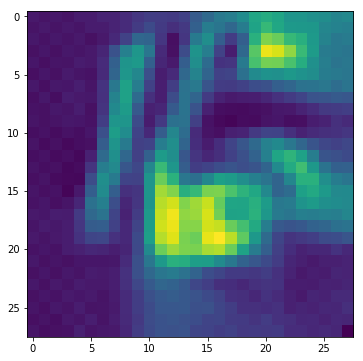

Activation for class: 7


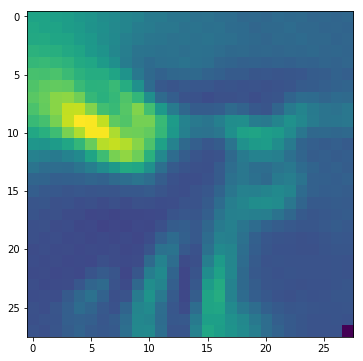

Activation for class: 8


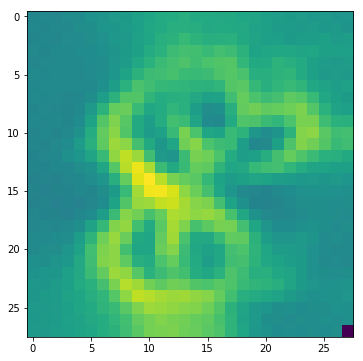

Activation for class: 9


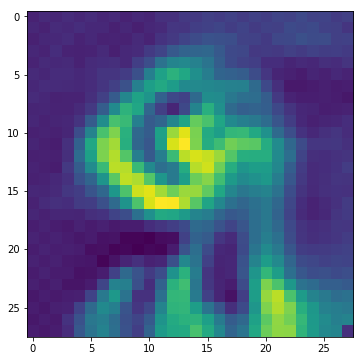

In [23]:
for i in range(10):
    print("Activation for class:", i)
    img = visualize_activation(model, layer_idx=-1, filter_indices=i, input_range=(0., 1.),
                               tv_weight=10, lp_norm_weight=10)
    _ = plt.imshow(img[..., 0])
    plt.show()

# How do these activation images change for a good model versus a not-so-good one?
### Lets compare our good model's activation images (deeper architecture & 10 epochs) with ones from a model trained only for 1 epoch and simpler architecture.

In [24]:
bad_model = Sequential()

bad_model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
bad_model.add(MaxPooling2D(pool_size=(2, 2)))
bad_model.add(Dropout(0.05))
bad_model.add(Flatten())
bad_model.add(Dense(64, activation='relu'))
bad_model.add(Dropout(0.25))
bad_model.add(Dense(num_classes, activation='softmax'))

# We are using Adadelta as the optimizer. It dynamically adapts the learning rate.
bad_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

bad_model.fit(X_train, y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(X_test, y_test))

score = bad_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 15s 249us/step - loss: 0.5106 - acc: 0.8472 - val_loss: 0.1835 - val_acc: 0.9456


Test loss: 0.18353071875870228
Test accuracy: 0.9456


In [25]:
# Swap softmax with linear
bad_model.layers[-1].activation = activations.linear
bad_model = utils.apply_modifications(bad_model)

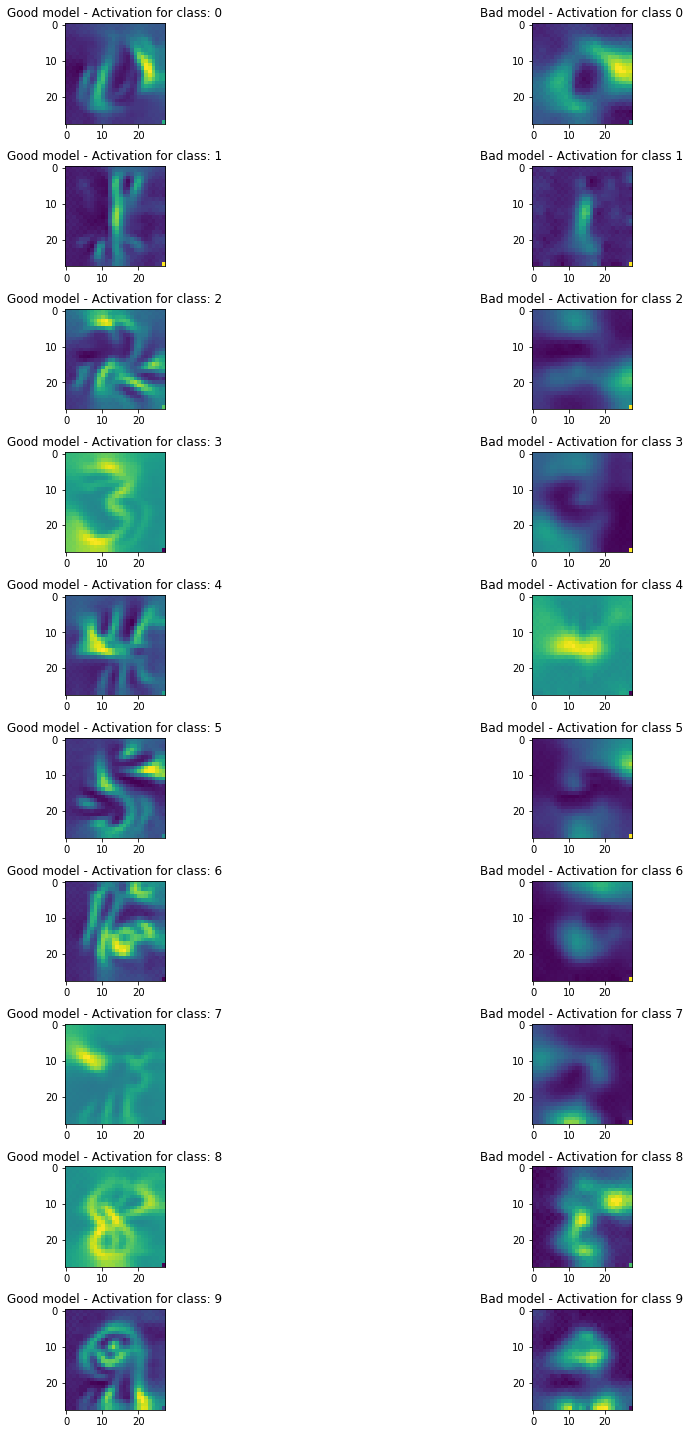

In [26]:
plt.rcParams['figure.figsize'] = (20, 20)

for i in range(num_classes):
    _ = plt.subplot(num_classes, 2, i+i+1)
    img = visualize_activation(model, layer_idx=-1, filter_indices=i, input_range=(0., 1.),
                           tv_weight=10, lp_norm_weight=10)
    _ = plt.imshow(img[..., 0])
    _ = plt.title("Good model - Activation for class: {}".format(i))

    _ = plt.subplot(num_classes, 2, i+i+2)
    img = visualize_activation(bad_model, layer_idx=-1, filter_indices=i, input_range=(0., 1.),
                               tv_weight=10, lp_norm_weight=10)
    _ = plt.imshow(img[..., 0])
    _ = plt.title("Bad model - Activation for class {}".format(i))
    
    plt.tight_layout()